# Welcome to ML4D BroadE!

### Agenda
10:00-10:05: Intro Videos, Demos and Downloads 

10:05-10:30: Run docker jupyter server and open broad.ipynb and run first cell

10:30-10:45: Fundamental ML (linear and logistic regression, SGD, depth and interpretation)

10:45-11:00: Train models on well-studied datasets (MNIST, CIFAR10)

11:00-11:30: ML4CVD Abstractions: Tensorization, TensorMaps and the ModelFactory

11:30-11:45: Coffee Break, Discussion and Data Exploration (groups coalesce: feature not bug)

11:45-11:55: Neurologist pep Talk from Chris Anderson

11:55-12:30: Defining TensorMaps on Qure.ai sets.

12:15-12:30: Training models on the datasets

12:30-12:45: Saliency Maps

12:45-12:59: Discussion and TensorMaps on your data, Tensorboard, Hyperparameter optimization


## Prerequisites
- Basic comfort with python, some linear algebra, some data science
- Download & Install Docker: https://docs.docker.com/install/
- Download ML4D_BroadE.zip from Google Drive: 
- Unzip ml-broade.zip
- Open a Command line terminal and `cd` to the ml-broade directory
- Build your docker! run `docker build -t ml4cvd-mkl .` (This will take a little while)
- One docker is built run the jupyter server: `docker run -it -p 8888:8888 -u $(id -u):$(id -g) --cpus=4 --memory=8g -v $PWD:/tf -it ml4cvd-mkl:latest`
- Download ml-broade-data folder (big or small depending on how much free space you have).
- Once data is downloaded, kill the jupyter server hold `ctrl-c` in the terminal and restart with: `docker run -it -v $HOME/ml-broade-data/:/data -p 6006:6006 -p 8888:8888 -u $(id -u):$(id -g) --cpus=4 --memory=8g -v $PWD:/tf -it ml4cvd-mkl:latest` (edit the path `$HOME/ml-broade-data/` to point at your data folder download location.)
- Click the trust button on your Jupyter notebook
- Now we are ready to teach the machines!

In [1]:
# Imports
import os
import sys
import pickle
import random
from typing import List, Dict, Callable
from collections import defaultdict, Counter

import csv
import gzip
import h5py
import shutil
import zipfile
import pydicom
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

from ml4cvd.defines import StorageType
from ml4cvd.arguments import parse_args, TMAPS, _get_tmap
from ml4cvd.TensorMap import TensorMap, Interpretation
from ml4cvd.tensor_generators import test_train_valid_tensor_generators
from ml4cvd.models import train_model_from_generators, make_multimodal_multitask_model, _inspect_model
from ml4cvd.recipes import test_multimodal_multitask, train_multimodal_multitask, saliency_maps

In [2]:
# Constants
ZIP_FOLDER = '/data/zips/' 
HD5_FOLDER = '/data/hd5s/'
MODEL_FOLDER = './models/'
EXCLUDE_SERIES = ['4cc', '_&_', '5mm', '3mm', 'helical']

# Python features we make lots of use of in this notebook:
- F Strings
- Callback Functions

### Linear Regression
We explore machine learning on Bio medical data using Cloud computing, Python, Tensorflow, and the ML4CVD codebase.

We will start with linear regression.  Our model is a vector, one weight for each input feature, and a single bias weight.

\begin{equation}
y = xw + b
\end{equation}

For notational convenience absorb the bias term into the weight vector by adding a 1 to the input data matrix $X$

\begin{equation}
y = [\textbf{1}, X][b, \textbf{w}]^T
\end{equation}

#### The Dense Layer is Matrix (Tensor) Multiplication
![Matrix Multiplication](https://www.mathwarehouse.com/algebra/matrix/images/matrix-multiplication/how-to-multiply-2-matrices-demo.gif)

In [ ]:
def linear_regression():
    samples = 40
    real_weight = 2.0
    real_bias = 0.5
    x = np.linspace(-1, 1, samples)
    y = real_weight*x + real_bias + (np.random.randn(*x.shape) * 0.1)

    linear_model = Sequential()
    linear_model.add(Dense(1, input_dim=1))
    linear_model.compile(loss='mean_squared_error', optimizer='sgd')
    linear_model.summary()
    linear_model.fit(x, y, batch_size=1, epochs=6)

    learned_slope = linear_model.get_weights()[0][0][0]
    learned_bias = linear_model.get_weights()[1][0]
    print('Learned slope:',  learned_slope, 'real slope:', real_weight, 'learned bias:', learned_bias, 'real bias:', real_bias)

    plt.plot(x, y)
    plt.plot([-1,1], [-learned_slope+learned_bias, learned_slope+learned_bias], 'r')
    plt.show()
    print('Linear Regression complete!')

In [ ]:
linear_regression()

## Now Logistic Regression:
We take the real-valued predictions from linear regression and squish them with a sigmoid.

\begin{equation}
\textbf{y} = \sigma(X\textbf{w} + b)
\end{equation}

where 
\begin{equation}
\sigma(x) = \frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}}
\end{equation}

In [3]:
def sigmoid(x):
    a = []
    for item in x:
        a.append(np.exp(item)/(1+np.exp(item)))
    return a

x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.show()

In [2]:
def logistic_regression(epochs = 600, num_labels = 10):
    train, test, valid = load_data('mnist.pkl.gz')  
    
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)

    logistic_model = Sequential()
    logistic_model.add(Dense(num_labels, activation='softmax', input_dim=784, name='mnist_templates'))
    logistic_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    logistic_model.summary()
    
    templates = logistic_model.layers[0].get_weights()[0]
    plot_templates(templates, 0)
    print('weights shape:', templates.shape)

    for e in range(epochs):
        trainidx = random.sample(range(0, train[0].shape[0]), 8192)
        x_batch = train[0][trainidx,:]
        y_batch = train_y[trainidx]
        logistic_model.train_on_batch(x_batch, y_batch)
        if e % 100 == 0:
            plot_templates(logistic_model.layers[0].get_weights()[0], e)
            print('Logistic Model test set loss and accuracy:', logistic_model.evaluate(test[0], test_y), 'at epoch', e)


def plot_templates(templates, epoch):
    n = 10
    templates = templates.reshape((28,28,n))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        ax = plt.subplot(2, 5, i+1)		
        plt.imshow(templates[:, :, i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plot_name = "./regression_example/mnist_templates_"+str(epoch)+".png"
    if not os.path.exists(os.path.dirname(plot_name)):
        os.makedirs(os.path.dirname(plot_name))		
    plt.savefig(plot_name)


def make_one_hot(y, num_labels):
    ohy = np.zeros((len(y), num_labels))
    for i in range(0, len(y)):
        ohy[i][y[i]] = 1.0
    return ohy


def load_data(dataset):
    ''' Loads the dataset
    :param dataset: the path to the dataset (here MNIST)'''
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the data directory.
        new_path = os.path.join("data", dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path

    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from urllib.request import urlretrieve
        origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        if not os.path.exists(os.path.dirname(dataset)):
            os.makedirs(os.path.dirname(dataset))	
        urlretrieve(origin, dataset)

    print('loading data...')
    f = gzip.open(dataset, 'rb')
    if sys.version_info[0] == 3:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        train_set, valid_set, test_set = u.load()
    else:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    return train_set, valid_set, test_set

def plot_mnist(sides):
    train, _, _ = load_data('mnist.pkl.gz')
    print(train[0].shape)
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    sides = int(np.ceil(np.sqrt(min(sides, mnist_images.shape[0]))))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    for i in range(sides*sides):
        axes[i // sides, i % sides].imshow(mnist_images[i, ..., 0], cmap='gray')

def mnist_as_hd5(hd5_folder):
    train, _, _ = load_data('mnist.pkl.gz')
    print(f' train 0 shape: {train[0].shape} train 1 shape {train[1].shape}')
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    if not os.path.exists(hd5_folder):
        os.makedirs(hd5_folder)
    for i, mnist_image in enumerate(mnist_images):
        with h5py.File(os.path.join(hd5_folder, f'{i}.hd5'), 'w') as hd5:
            hd5.create_dataset('mnist_image', data=mnist_image)
            hd5.create_dataset('mnist_label', data=[train[1][i]])
        
        

# Look B4 U Learn!

In [19]:
mnist_as_hd5('./mnist_hd5s/')

loading data...
 train 0 shape: (50000, 784) train 1 shape (50000,)


In [2]:
def mnist_image_from_hd5(tm, hd5, dependents={}):
     return np.array(hd5['mnist_image'])

def mnist_label_from_hd5(tm, hd5, dependents={}):
    one_hot = np.zeros(tm.shape, dtype=np.float32)
    one_hot[int(hd5['mnist_label'][0])] = 1.0
    return one_hot
    
TMAPS['mnist_image'] = TensorMap('mnist_image', shape=(28, 28, 1), tensor_from_file=mnist_image_from_hd5)
TMAPS['mnist_label'] = TensorMap('mnist_label', Interpretation.CATEGORICAL, tensor_from_file=mnist_label_from_hd5,
                                 channel_map={f'digit_{i}': i for i in range(10)})


In [3]:
sys.argv = ['train', 
            '--tensors', './mnist_hd5s/', 
            '--input_tensors', 'mnist_image',
            '--output_tensors', 'mnist_label',
            '--test_steps', '300',
            '--epochs', '4',
            '--id', 'learn_mnist'
           ]
args = parse_args()
train_multimodal_multitask(args)

2020-05-20 16:07:00,021 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/learn_mnist/log_2020-05-20_16-07_0.log.
2020-05-20 16:07:00,022 - arguments:372 - INFO - Command Line was: 
./scripts/tf.sh train --tensors ./mnist_hd5s/ --input_tensors mnist_image --output_tensors mnist_label --test_steps 300 --epochs 4 --id learn_mnist

2020-05-20 16:07:00,023 - arguments:373 - INFO - Total TensorMaps: 558 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=2.0, anneal_rate=0.0, anneal_shift=0.0, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=16, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, bottleneck_type=<BottleneckType.FlattenRestructure: 1>, cache_size=875000000.0, categorical_field_ids=[], continuous_field_ids=[], continuous_file=None, continuous_file_column=None, continuou

2020-05-20 16:07:04,233 - tensor_generators:149 - INFO - Started 3 train workers with cache size 0.875GB.
2020-05-20 16:07:04,397 - tensor_generators:149 - INFO - Started 1 validation workers with cache size 0.875GB.
Train for 400 steps, validate for 40 steps
Epoch 1/4
398/400 [============================>.] - ETA: 0s - loss: 1.9148 - categorical_accuracy: 0.3866 - digit_0_precision: 0.2561 - digit_1_precision: 0.2845 - digit_2_precision: 0.0754 - digit_3_precision: 0.0050 - digit_4_precision: 0.1256 - digit_5_precision: 0.0000e+00 - digit_6_precision: 0.1432 - digit_7_precision: 0.1367 - digit_8_precision: 0.0440 - digit_9_precision: 0.0239 - digit_0_recall: 0.2334 - digit_1_recall: 0.2814 - digit_2_recall: 0.0529 - digit_3_recall: 0.0021 - digit_4_recall: 0.1082 - digit_5_recall: 0.0000e+00 - digit_6_recall: 0.1214 - digit_7_recall: 0.1093 - digit_8_recall: 0.0319 - digit_9_recall: 0.0173      
Epoch 00001: val_loss improved from inf to 1.09424, saving model to ./recipes_output/lear

2020-05-20 16:08:02,276 - tensor_generators:213 - INFO - Stopped 4 workers.
2020-05-20 16:08:02,300 - tensor_generators:213 - INFO - Stopped 2 workers.
2020-05-20 16:08:02,302 - models:1086 - INFO - Model weights saved at: ./recipes_output/learn_mnist/learn_mnist.h5
2020-05-20 16:08:08,194 - plots:203 - INFO - Saved learning curves at:./recipes_output/learn_mnist/metric_history_learn_mnist.png
2020-05-20 16:08:08,333 - tensor_generators:149 - INFO - Started 3 test workers with cache size 0.0GB.
2020-05-20 16:08:11,002 - tensor_generators:403 - WARNING - Test worker test_worker_0 completed a full epoch. Test results may be double counting samples.
2020-05-20 16:08:11,026 - tensor_generators:472 - INFO - Made a big batch of tensors with key:input_mnist_image_continuous and shape:(4800, 28, 28, 1).
2020-05-20 16:08:11,028 - tensor_generators:472 - INFO - Made a big batch of tensors with key:output_mnist_label_categorical and shape:(4800, 10).
2020-05-20 16:08:11,060 - tensor_generators:40

{'digit_0': 0.9994072829418441,
 'digit_1': 0.9989927736924202,
 'digit_2': 0.9969640627465777,
 'digit_3': 0.997153939829099,
 'digit_4': 0.9990085602118797,
 'digit_5': 0.9991859351800887,
 'digit_6': 0.9995755858579529,
 'digit_7': 0.9966118795387089,
 'digit_8': 0.9971490147570238,
 'digit_9': 0.997507164981145}

loading data...
(50000, 784)


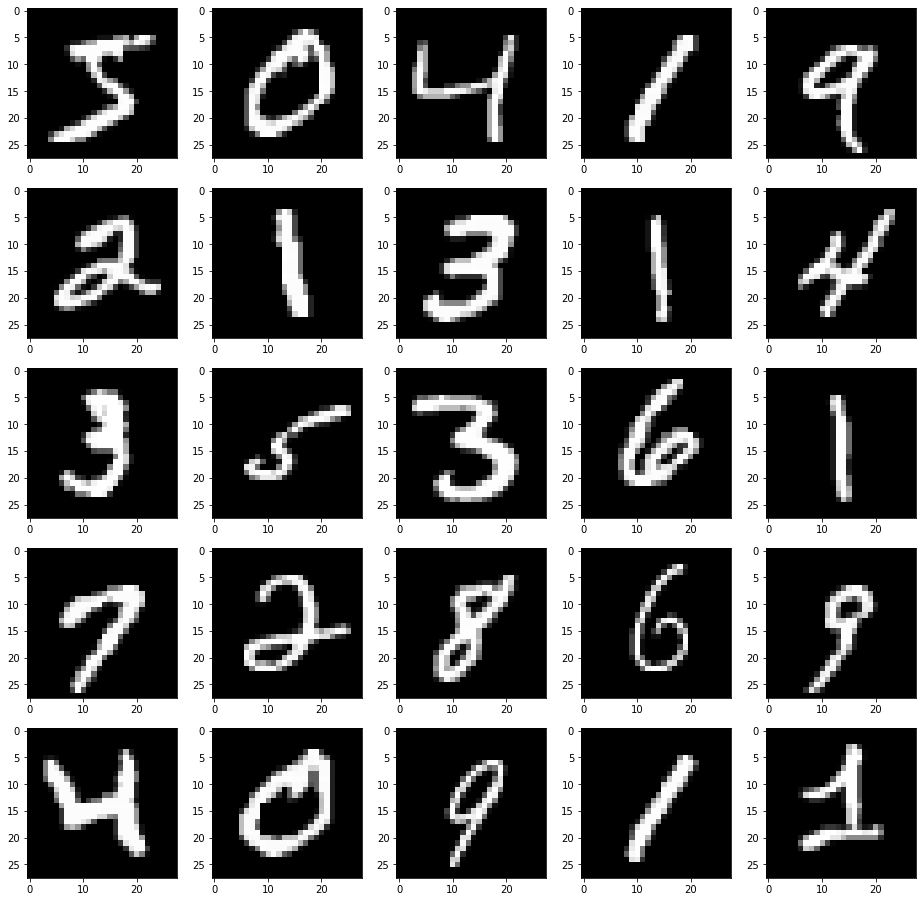

In [8]:
plot_mnist(25)

## Cross Entropy Loss:
Our favorite loss function for categorical data.
\begin{equation}
L(true, model) = -\sum_{x\in\mathcal{X}} true(x)\, \log model(x)
\end{equation}

Binary cross entropy with $N$ data points $x$ each with a binary label: 
\begin{equation}
true(x) \in \{0, 1\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1} true(x_i)\log(model(x_i)) + (1-true(x_i))log(1-model(x_i))
\end{equation}

This is the Kullback Leibler divergence between the true distribution and the predicted. 
This function emerges in many fields as diverse as probability, information theory, and physics.
What is the information difference between the truth and our model?  How much data do I lose by replacing the truth with the model's predictions. What is the temperature difference between my predictions and the truth?!

Categorical cross entropy with $K$ different classes or labels: 
\begin{equation}
true(x) \in \{0, 1, 2, ..., K\} \\
L(true, model) = -\frac{1}{N}\sum^N_{i=1}\sum^K_{j=1} y_{ik}\log(q_k(x_i)))
\end{equation}

In [ ]:
logistic_regression()

# Deep Models: "Hidden" Layers and The MultiLayerPerceptron

In [ ]:
def multilayer_perceptron():
    train, test, valid = load_data('mnist.pkl.gz')

    num_labels = 10
    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)

    mlp_model = Sequential()
    mlp_model.add(Dense(500, activation='relu', input_dim=784))
    mlp_model.add(Dense(num_labels, activation='softmax'))
    mlp_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    mlp_model.summary()
    mlp_model.fit(train[0], train_y, validation_data=(valid[0],valid_y), batch_size=32, epochs=3)
    print('Multilayer Perceptron trained. Test set loss and accuracy:', mlp_model.evaluate(test[0], test_y))

multilayer_perceptron()

# Convolutions Flip, Slide, Multiply, Add
Convolutions look for their kernel in a larger signal.

In convolution, you always and only find what you're looking with.

Convolution and cross correlation are deeply related:

\begin{equation}
f(t) \circledast g(t) \triangleq\ \int_{-\infty}^\infty f(\tau) g(t - \tau) \, d\tau. = \int_{-\infty}^\infty f(t-\tau) g(\tau)\, d\tau.
\end{equation}



![title](https://upload.wikimedia.org/wikipedia/commons/2/21/Comparison_convolution_correlation.svg)

In [ ]:
def convolutional_neural_network(filters=32, kernel_size=(3,3), padding='valid', num_labels = 10):
    train, test, valid = load_data('mnist.pkl.gz')

    train_y = make_one_hot(train[1], num_labels)
    valid_y = make_one_hot(valid[1], num_labels)
    test_y = make_one_hot(test[1], num_labels)
    
    print(train[0].shape)
    mnist_images = train[0].reshape((-1, 28, 28, 1))
    mnist_valid = valid[0].reshape((-1, 28, 28, 1))
    mnist_test = test[0].reshape((-1, 28, 28, 1))

    cnn_model = Sequential()
    cnn_model.add(Conv2D(input_shape=(28, 28, 1), filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='relu'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(16, activation='relu'))
    cnn_model.add(Dense(num_labels, activation='softmax'))
    cnn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    cnn_model.summary()
    cnn_model.fit(mnist_images, train_y, validation_data=(mnist_valid, valid_y), batch_size=32, epochs=3)
    
    print('Convolutional Neural Network trained. Test set loss and accuracy:', cnn_model.evaluate(mnist_test, test_y))

convolutional_neural_network()

# Why (and When!) is Convolution Helpful?
- Decouples input size from model size
- Translationally Equivariant (Not Invariant), so we can find features wherever they might occur in the signal
- Local structure is often informative
- But not always! (eg Tabular data)

# ML4CVD Cosmology:  Tensors all the way down.


# ML4CVD Abstractions: Tensorization, the TensorMap, and the ModelFactory

## Tensorization
Tensorization is the process of gathering any number of input files and consolidating them into compressed HD5 files.  We tend to make one HD5 file per sample in the study.  The files contain the raw data and labels we will use to train models.  It tends to be efficient to separate tensor construction from model training.

In [ ]:
def parse_dicoms(dicom_folder, stats):
    dcm_file = ''
    my_stats = Counter()
    series = defaultdict(list)
    for root, _, files in os.walk(dicom_folder):
        for name in files:
            dcm_file = os.path.join(root, name)
            if not dcm_file.endswith('.dcm'):
                continue
            try:
                dcm = pydicom.read_file(dcm_file)
                my_stats[f'Shape {dcm.pixel_array.shape}'] += 1
                my_stats['count'] += 1
                my_stats[f'Series Number {dcm.SeriesNumber}'] += 1
                my_stats[f'Series Description {dcm.SeriesDescription}'] += 1
                my_stats[f'Pixel spacing{dcm.PixelSpacing}'] += 1
                series[dcm.SeriesDescription.lower().trim().replace(' ', '_').replace('/', '_')].append(dcm)
            except:
                my_stats['got an error'] += 1
                break
    print(f'\n At DICOM {dcm_file}')
    for k in my_stats:
        print(f'{k} has {my_stats[k]}') 
    
    try:
        tensors = {}
        for k in series:
            tensors[k] = np.zeros((512, 512, len(series[k])))
            for dcm in series[k]:
                tensors[k][..., dcm.InstanceNumber-1] = dcm.pixel_array
    except:
        my_stats['got a tensorization error'] += 1
            
    stats.update(my_stats)
    return tensors

In [ ]:
def tensorize_qure_ai_dicoms(zip_folder, dicom_folder, hd5_folder, delete_dicoms=True, limit_dicoms=-1):
    raw_data = {}
    stats = Counter()
    if not os.path.exists(dicom_folder):
        os.makedirs(dicom_folder)
    if not os.path.exists(hd5_folder):
        os.makedirs(hd5_folder)    
    for z in os.listdir(zip_folder):
        if os.path.exists(os.path.join(hd5_folder, z.replace('.zip', '.hd5'))):
            continue
        with zipfile.ZipFile(zip_folder + z, "r") as zip_ref:
            zip_ref.extractall(dicom_folder)
            tensors = parse_dicoms(dicom_folder, stats)
            with h5py.File(os.path.join(hd5_folder, z.replace('.zip', '.hd5')), 'w') as hd5:
                for t in tensors:
                    hd5.create_dataset(t, data=tensors[t], compression='gzip')
        if delete_dicoms:
            shutil.rmtree(dicom_folder)
        if limit_dicoms > 0 and stats['count'] > limit_dicoms:
            break

    print('\n\n Full stats below:')
    for k in stats:
        print(f'{k} has {stats[k]}')

tensorize_qure_ai_dicoms(ZIP_FOLDER, './dicoms/', './test/', limit_dicoms=1000)

In [ ]:
!head -5 ./reads.csv 

In [ ]:
def tensorize_qure_ai_reads(read_file, hd5_folder):
    stats = Counter()
    with open(read_file, 'r') as my_csv:
        lol = list(csv.reader(my_csv, delimiter=','))
        header = [h.replace(':', '_').lower() for h in lol[0]]
        print(f'header is {header}')
        for row in lol[1:]:
            try:
                with h5py.File(f'{hd5_folder}{row[0]}.hd5', 'a') as hd5:
                    for i, value in enumerate(row[2:]):
                        hd5.create_dataset(header[i+2], data=[int(value)])
            except:
                print(f'Could not open {row[0]}')
    for k in stats:
        print(f'{k} has {stats[k]}')

### Look at the DICOM series we have

## TensorMaps
The critical data structure in the ML4CVD codebase is the TensorMap.
This abstraction provides a way to translate ***any*** kind of input data, into structured numeric tensors with clear semantics for interpretation and modeling.  TensorMaps guarantee a shape, a way to consturct tensors of that shape from the HD5 files created during tensorization and a meaning to the values in the tensor that the TensorMap yields.

In [ ]:
mnist_image = TensorMap('mnist_image', Interpretation.CONTINUOUS, shape=(28, 28))
mnist_image = TensorMap('mnist_image', Interpretation.CONTINUOUS, shape=(28, 28, 1))

mnist_channel_map = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'zero': 4, 'zero': 5, 
                     'six': 6, 'seven': 9, 'eight': 8, 'nine': 9}

mnist_class = TensorMap('mnist_class', Interpretation.CATEGORICAL, shape=(10,), channel_map=mnist_channel_map)

In [ ]:
cifar_image = TensorMap('cifar_image', Interpretation.CONTINUOUS, shape=(32, 32, 3))

cifar_channel_map = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 
                     'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

cifar_class = TensorMap('cifar_class', Interpretation.CATEGORICAL, shape=(10,), channel_map=cifar_channel_map)

In [ ]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap]):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    if os.path.isfile(path):
        with h5py.File(path, 'r') as hd5:
            for tmap in tmaps:
                try:
                    result_dict[tmap] = tmap.normalize_and_validate(tmap.tensor_from_file(tmap, hd5))
                except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                    continue
    return result_dict

In [ ]:
def plot_array_3d(a):
    slice_axis = -1
    sides = int(np.ceil(np.sqrt(a.shape[slice_axis])))
    _, axes = plt.subplots(sides, sides, figsize=(16, 16))
    print(a.shape)
    vmin = np.min(a)
    vmax = np.max(a)
    for i in range(a.shape[slice_axis]):
        axes[i//sides, i%sides].imshow(a[..., i], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i//sides, i%sides].set_yticklabels([])
        axes[i//sides, i%sides].set_xticklabels([])

In [ ]:
def slice_map(exclude=EXCLUDE_SERIES):
    def slice_from_hd5(tm, hd5, dependents={}):
        for k in np.random.permutation(list(hd5.keys())):
            if any(x in k for x in exclude):
                continue
            if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] > 50:
                random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
                random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
                return random_slices
        raise ValueError('No CT slices in HD5')
    return slice_from_hd5
   
TMAPS['slice_map'] = TensorMap('slice_map', shape=(512, 512, 1), tensor_from_file=slice_map(), 
                               cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['slice_map5'] = TensorMap('slice_map5', shape=(512, 512, 5), tensor_from_file=slice_map(), 
                                cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['slice_map25'] = TensorMap('slice_map25', shape=(512, 512, 25), tensor_from_file=slice_map(), 
                                 cacheable=False, normalization={'zero_mean_std1': True})

In [ ]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-222', [ _get_tmap('slice_map25')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])

In [ ]:
def crop_voxels(exclude=EXCLUDE_SERIES):
    def crop_voxels_from_hd5(tm, hd5, dependents={}):
        for k in np.random.permutation(list(hd5.keys())):
            if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3:
                if any(x in k for x in exclude):
                    continue
                if hd5[k].shape[-1] < 50:
                    continue
                x_index = np.random.randint(hd5[k].shape[0]-tm.shape[0])
                y_index = np.random.randint(hd5[k].shape[1]-tm.shape[1])
                middle_index = hd5[k].shape[-1] // 2
                start_index = middle_index - (tm.shape[-1] // 2)
                stop_index = middle_index + (tm.shape[-1] // 2) + tm.shape[-1]%2
                z_index = np.random.randint(hd5[k].shape[2]-tm.shape[2])
                random_slices = np.array(hd5[k][x_index:x_index+tm.shape[0], y_index:y_index+tm.shape[1], start_index:stop_index], dtype=np.float32)
                return random_slices
        raise ValueError('No CT slices in HD5')
    return crop_voxels_from_hd5

TMAPS['crop_thin_16'] = TensorMap('crop_thin_16', shape=(16, 16, 16), tensor_from_file=crop_voxels(), 
                                  cacheable=False, normalization={'zero_mean_std1': True})
    
TMAPS['crop_thin_64'] = TensorMap('crop_thin_64', shape=(64, 64, 64), tensor_from_file=crop_voxels(), 
                                  cacheable=False, normalization={'zero_mean_std1': True})

TMAPS['crop_thin_316'] = TensorMap('crop_thin_316', shape=(316, 192, 64), tensor_from_file=crop_voxels(), 
                                   cacheable=False, normalization={'zero_mean_std1': True})

TMAPS['crop_thin_372'] = TensorMap('crop_thin_372', shape=(372, 292, 121), tensor_from_file=crop_voxels(), 
                                   cacheable=False, normalization={'zero_mean_std1': True})

TMAPS['crop_thin_256'] = TensorMap('crop_thin_256', shape=(256, 256, 128), tensor_from_file=crop_voxels(), 
                                   cacheable=False, normalization={'zero_mean_std1': True})

TMAPS['crop_thin_396'] = TensorMap('crop_thin_396', shape=(396, 396, 144), tensor_from_file=crop_voxels(), 
                                   cacheable=False, normalization={'zero_mean_std1': True})


In [ ]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-212', [ _get_tmap('crop_thin_316')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])

In [ ]:
def thin_slice(exclude=EXCLUDE_SERIES):
    def thin_slice_from_hd5(tm, hd5, dependents={}):
        for k in np.random.permutation(list(hd5.keys())):
            if any(x in k for x in exclude):
                continue
            if hd5[k].shape[-1] < 50:
                continue
            if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3:
                random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
                random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
                random_slices = np.clip(random_slices, 3000, 10000)
                return random_slices
        raise ValueError('No CT slices in HD5')
    return thin_slice_from_hd5
    
TMAPS['thin_slice_map16'] = TensorMap('thin_slice_map16', shape=(512, 512, 16), tensor_from_file=thin_slice([]), 
                                      cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['thin_slice_map50'] = TensorMap('thin_slice_map50', shape=(512, 512, 50), tensor_from_file=thin_slice([]), 
                                      cacheable=False, normalization={'zero_mean_std1': True})
TMAPS['thin_slice_map200'] = TensorMap('thin_slice_map200', shape=(512, 512, 200), tensor_from_file=thin_slice(), 
                                       cacheable=False, normalization={'zero_mean_std1': True})

In [ ]:
t = tmaps_by_sample_id(HD5_FOLDER, 'CQ500-CT-212', [ _get_tmap('thin_slice_map50')])
for k in t:
    print(k.name, 'has', t[k].shape)
    plot_array_3d(t[k])   

## Start with something simple and obvious for a human

In [ ]:
def slice_count(exclude=EXCLUDE_SERIES):
    def slice_count_hd5(tm, hd5, dependents={}):
        for k in np.random.permutation(list(hd5.keys())):
            if any(x in k for x in exclude):
                continue
            if isinstance(hd5[k], h5py.Dataset) and len(hd5[k].shape) == 3 and hd5[k].shape[-1] > 50:
                random_index = np.random.randint(hd5[k].shape[-1]-tm.shape[-1])
                random_slices = np.array(hd5[k][..., random_index:random_index+tm.shape[-1]], dtype=np.float32)
                dependents[tm.dependent_map] = np.sum(random_slices > 800) / np.prod(random_slices.shape)
                return random_slices
        raise ValueError('No CT slices in HD5')
    return slice_count_hd5

TMAPS['slice_map_count'] = TensorMap('slice_map_count', shape=(1,), channel_map={'count': 0}, cacheable=False)
TMAPS['slice_map_to_count'] = TensorMap('slice_map', shape=(512, 512, 2), dependent_map=TMAPS['slice_map_count'],
                                        tensor_from_file=slice_count(), cacheable=False, 
                                        normalization={'zero_mean_std1': True})

In [ ]:
TMAPS['r1_fracture'] = TensorMap('r1_fracture', Interpretation.CATEGORICAL, 
                                 storage_type=StorageType.CATEGORICAL_INDEX, 
                                 channel_map={'no_r1_fracture': 0, 'r1_fracture': 1})
TMAPS['r2_fracture'] = TensorMap('r2_fracture', Interpretation.CATEGORICAL, 
                                 storage_type=StorageType.CATEGORICAL_INDEX, 
                                 channel_map={'no_r2_fracture': 0, 'r2_fracture': 1})
TMAPS['r3_fracture'] = TensorMap('r3_fracture', Interpretation.CATEGORICAL, 
                                 storage_type=StorageType.CATEGORICAL_INDEX, 
                                 channel_map={'no_r3_fracture': 0, 'r3_fracture': 1})
TMAPS['r1_calvarialfracture'] = TensorMap('r1_calvarialfracture', Interpretation.CATEGORICAL, 
                                          storage_type=StorageType.CATEGORICAL_INDEX, 
                                          channel_map={'no_r1_calvarialfracture': 0, 'r1_calvarialfracture': 1})
TMAPS['r2_calvarialfracture'] = TensorMap('r2_calvarialfracture', Interpretation.CATEGORICAL, 
                                          storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_calvarialfracture': 0, 'r2_calvarialfracture': 1})
TMAPS['r3_calvarialfracture'] = TensorMap('r3_calvarialfracture', Interpretation.CATEGORICAL, 
                                          storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_calvarialfracture': 0, 'r3_calvarialfracture': 1})

TMAPS['r1_masseffect'] = TensorMap('r1_masseffect', Interpretation.CATEGORICAL, 
                                   storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r1_masseffect': 0, 'r1_masseffect': 1})
TMAPS['r2_masseffect'] = TensorMap('r2_masseffect', Interpretation.CATEGORICAL, 
                                   storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r2_masseffect': 0, 'r2_masseffect': 1})
TMAPS['r3_masseffect'] = TensorMap('r3_masseffect', Interpretation.CATEGORICAL, 
                                   storage_type=StorageType.CATEGORICAL_INDEX, channel_map={'no_r3_masseffect': 0, 'r3_masseffect': 1})

TMAPS['r1_ich'] = TensorMap('r1_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r1_ich': 0, 'r1_ich': 1})
TMAPS['r2_ich'] = TensorMap('r2_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r2_ich': 0, 'r2_ich': 1})
TMAPS['r3_ich'] = TensorMap('r3_ich', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r3_ich': 0, 'r3_ich': 1})

TMAPS['r1_iph'] = TensorMap('r1_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r1_iph': 0, 'r1_iph': 1})
TMAPS['r2_iph'] = TensorMap('r2_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r2_iph': 0, 'r2_iph': 1})
TMAPS['r3_iph'] = TensorMap('r3_iph', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r3_iph': 0, 'r3_iph': 1})

TMAPS['r1_midlineshift'] = TensorMap('r1_midlineshift', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r1_midlineshift': 0, 'r1_midlineshift': 1})
TMAPS['r2_midlineshift'] = TensorMap('r2_midlineshift', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r2_midlineshift': 0, 'r2_midlineshift': 1})
TMAPS['r3_midlineshift'] = TensorMap('r3_midlineshift', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r3_midlineshift': 0, 'r3_midlineshift': 1})

TMAPS['r1_sah'] = TensorMap('r1_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r1_sah': 0, 'r1_sah': 1})
TMAPS['r2_sah'] = TensorMap('r2_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r2_sah': 0, 'r2_sah': 1})
TMAPS['r3_sah'] = TensorMap('r3_sah', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r3_sah': 0, 'r3_sah': 1})

TMAPS['r1_sdh'] = TensorMap('r1_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r1_sdh': 0, 'r1_sdh': 1})
TMAPS['r2_sdh'] = TensorMap('r2_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r2_sdh': 0, 'r2_sdh': 1})
TMAPS['r3_sdh'] = TensorMap('r3_sdh', Interpretation.CATEGORICAL, storage_type=StorageType.CATEGORICAL_INDEX, 
                            channel_map={'no_r3_sdh': 0, 'r3_sdh': 1})

TMAPS['r1_chronicbleed'] = TensorMap('r1_chronicbleed', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r1_chronicbleed': 0, 'r1_chronicbleed': 1})
TMAPS['r2_chronicbleed'] = TensorMap('r2_chronicbleed', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r2_chronicbleed': 0, 'r2_chronicbleed': 1})
TMAPS['r3_chronicbleed'] = TensorMap('r3_chronicbleed', Interpretation.CATEGORICAL, 
                                     storage_type=StorageType.CATEGORICAL_INDEX, 
                                     channel_map={'no_r3_chronicbleed': 0, 'r3_chronicbleed': 1})

# The Model Factory
The function ***make_multimodal_multitask_model()*** takes lists of TensorMaps and connects them with intelligent goo.
### Model Architectures
- Classification
- Regression
- Multitask
- Multimodal
- Multimodal Multitask
- Autoencoders

## Binary Classification of CT Slice Command Line & Architecture
Jupyter is great, but can complicate productionizing code. We try to mitigate this by interacting with the jupyter notebook as if it were a command line call to one of ML4CVD's modes. 

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'r1_masseffect',
            '--dense_blocks', '12', '12', '8', '8',
            '--num_workers', '0', '--cache_size', '0',
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_model.png')

![My First Model Architecture](./my_first_model.png)

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map_to_count',
            '--output_tensors', 'slice_map_count',
            '--pool_x', '6', '--pool_y', '6',
            '--id', 'slice_map_to_count',
            '--output_folder', MODEL_FOLDER,
            '--epochs', '2',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '48', 
            '--test_ratio', '0.3', 
            '--test_modulo', '0', 
            '--batch_size', '4',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
train_multimodal_multitask(args)

### Test a Pretrained Model

In [ ]:
sys.argv = ['test_scalar', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map_to_count',
            '--output_tensors', 'slice_map_count', 'r1_midlineshift', 'r2_midlineshift', 'r3_midlineshift',
            '--id', 'slice_map_to_count',
            '--output_folder', MODEL_FOLDER,
            '--model_file', f'{MODEL_FOLDER}/slice_map_to_count/slice_map_to_count.hd5',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '48', 
            '--test_ratio', '0.3', 
            '--test_modulo', '0', 
            '--batch_size', '4',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
test_multimodal_multitask(args)

## Multitask Architecture

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'r1_midlineshift', 'r2_midlineshift', 'r3_midlineshift',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_multitask_model.png')

![multitask](./my_first_multitask_model.png)

## Multimodal Architecture

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_16', 'crop_thin_64',
            '--output_tensors', 'r1_midlineshift',
            '--dense_blocks', '12', '12', '8', '8',
            '--test_ratio', '0.3',
            '--num_workers', '0',
            '--cache_size', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_first_multimodal_model.png')

![Multimodal](./my_first_multimodal_model.png)

## CT Slice AutoEncoder

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'crop_thin_64',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_ct_slice_autoencoder.png')

![ct auto encoder](./my_ct_slice_autoencoder.png)

# U Net

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'crop_thin_64',
            '--u_connect',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_ct_slice_unet_autoencoder.png')

![unet](./my_ct_slice_unet_autoencoder.png)

## Beware of the Irony of Command Line Hyperparameter Tuning

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'r1_calvarialfracture', 'r1_masseffect',
            '--output_folder', MODEL_FOLDER,
            '--activation', 'prelu',
            '--dense_blocks', '32', '24', '16', '12', '8', '6',
            '--dense_layers', '32', '32', '32',
            '--block_size', '5',
            '--pool_x', '2',
            '--pool_y', '2',
            '--id', 'middle_slices_16_r1_calvarialfracture_mass_effect',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '2', 
            '--test_ratio', '0.1', 
            '--test_modulo', '0', 
            '--batch_size', '6',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
_inspect_model(model, generate_train, generate_valid, 1, 1, True, './my_hypertune.png')

![hyper](./my_hypertune.png)

# Saliency Maps

In [ ]:
sys.argv = ['plot_saliency', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'slice_map_to_count',
            '--output_tensors', 'slice_map_count',
            '--id', 'slice_map_to_count',
            '--output_folder', MODEL_FOLDER,
            '--model_file', f'{MODEL_FOLDER}/slice_map_to_count/slice_map_to_count.hd5',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '4', 
            '--test_ratio', '0.3', 
            '--test_modulo', '0', 
            '--batch_size', '4',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()

generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
saliency_maps(args)

# t-SNE of learned Representations

![t-SNE](./models/slice_map_to_count/tsne_plot.png)

## Overfit:

In [ ]:
sys.argv = ['train', 
            '--tensors', HD5_FOLDER, 
            '--input_tensors', 'crop_thin_64',
            '--output_tensors', 'r1_calvarialfracture', 'r1_masseffect',
            '--output_folder', MODEL_FOLDER,
            '--dense_blocks', '32', '24',
            '--pool_x', '4',
            '--pool_y', '4',
            '--id', 'middle_slices_16_r1_calvarialfracture_mass_effect',
            '--epochs', '18',
            '--training_steps', '48', 
            '--validation_steps', '22', 
            '--valid_ratio', '0.3', 
            '--test_steps', '2', 
            '--test_ratio', '0.1', 
            '--test_modulo', '0', 
            '--batch_size', '6',
            '--cache_size', '0',
            '--num_workers', '0'
           ]
args = parse_args()
train_multimodal_multitask(args)